In [21]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from evaluate_utils import *
from sklearn.metrics import f1_score

In [22]:
train_previous_increase_ratio = np.load("../data/interim/stock500_2023_2024_previous_increase_ratio.npz")["previous_increase_ratio"]
train_post_increase_ratio = np.load("../data/interim/stock500_2023_2024_post_increase_ratio.npz")["post_increase_ratio"]
test_previous_increase_ratio = np.load("../data/interim/stock500_20250101_20250430_previous_increase_ratio.npz")["previous_increase_ratio"]
test_post_increase_ratio = np.load("../data/interim/stock500_20250101_20250430_post_increase_ratio.npz")["post_increase_ratio"]
valid_train_samples = (np.min(train_previous_increase_ratio, axis=1) > 0) & (np.min(train_post_increase_ratio, axis=1) > 0)
valid_test_samples = (np.min(test_previous_increase_ratio, axis=1) > 0) & (np.min(test_post_increase_ratio, axis=1) > 0)
train_previous_increase_ratio = train_previous_increase_ratio[valid_train_samples]
train_post_increase_ratio = train_post_increase_ratio[valid_train_samples]
test_previous_increase_ratio = test_previous_increase_ratio[valid_test_samples]
test_post_increase_ratio = test_post_increase_ratio[valid_test_samples]
# 数据标签
train_scores = np.max(train_post_increase_ratio, axis=1)
train_labels = np.max(train_post_increase_ratio, axis=1) >= 1.05
test_scores = np.max(test_post_increase_ratio, axis=1)
test_labels = np.max(test_post_increase_ratio, axis=1) >= 1.05
print("Shape of train_previous_increase_ratio: ", train_previous_increase_ratio.shape)
print("Shape of test_previous_increase_ratio: ", test_previous_increase_ratio.shape)
print("Shape of train_post_increase_ratio: ", train_post_increase_ratio.shape)
print("Shape of test_post_increase_ratio: ", test_post_increase_ratio.shape)
print("Number of positive samples in train data: ", train_labels.sum())
print("Number of positive samples in test data: ", test_labels.sum())

Shape of train_previous_increase_ratio:  (108998, 30)
Shape of test_previous_increase_ratio:  (22146, 30)
Shape of train_post_increase_ratio:  (108998, 5)
Shape of test_post_increase_ratio:  (22146, 5)
Number of positive samples in train data:  17986
Number of positive samples in test data:  5535


In [23]:
import faiss
train_embeddings = np.load("../data/interim/stock500_2023_2024_embeddings.npz")["embeddings"]
print(train_embeddings.shape)
train_embeddings = train_embeddings[valid_train_samples]
test_embeddings = np.load("../data/interim/stock500_20250101_20250430_embeddings.npz")["embeddings"]
print(test_embeddings.shape)
test_embeddings = test_embeddings[valid_test_samples]
norms_train = np.linalg.norm(train_embeddings, axis=1, keepdims=True)
normed_train_embeddings = train_embeddings / norms_train  # 归一化后的数据
norms_test = np.linalg.norm(test_embeddings, axis=1, keepdims=True)
normed_test_embeddings = test_embeddings / norms_test  # 归一化后的数据
index = faiss.IndexFlatIP(train_embeddings.shape[1])
index.add(train_embeddings)

(261560, 256)
(23641, 256)


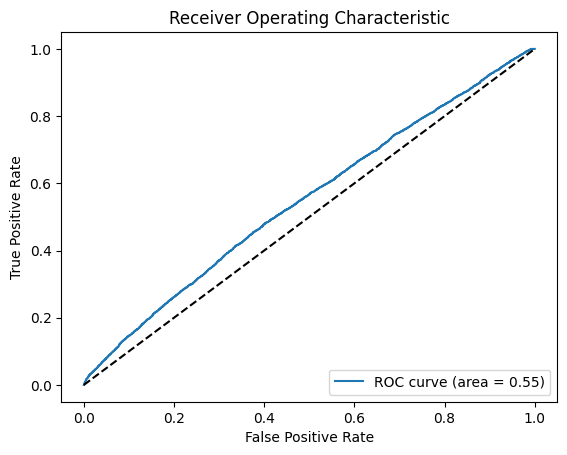

{'p90_th': 1.0735305038058343, 'p90_re': 0.0001806684733514002, 'p80_th': 1.0735305038058343, 'p80_re': 0.0001806684733514002, 'p70_th': 1.0735305038058343, 'p70_re': 0.0001806684733514002, 'p60_th': 1.0664810517906136, 'p60_re': 0.0003613369467028004, 'p50_th': 1.0496051962864672, 'p50_re': 0.008491418247515809}


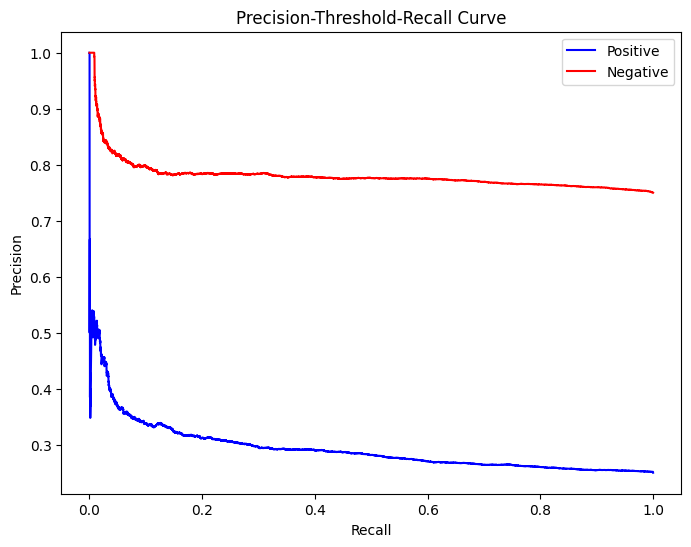

0.016702203269367447
0.0167 0.5494 1.0735 0.0002 1.0735 0.0002 1.0735 0.0002 1.0665 0.0004 1.0496 0.0085


In [24]:
neighbors = index.search(normed_test_embeddings, 50)[1]
predictions = []
for i in range(test_previous_increase_ratio.shape[0]):
    predictions.append(np.median(train_scores[neighbors[i]]))
predictions = np.array(predictions)
model_name = f"knn+tstransformer"
metrics = {"model_name": f"knn+tstransformer"}
auc = plot_roc_curve(predictions, test_labels, model_name)
metrics["auc"] = auc
precision_threshold_recall_dict = plot_precision_threshold_recall(predictions, test_labels, model_name)
metrics.update(precision_threshold_recall_dict)
metrics["f1_score"] = f1_score(test_labels, predictions > metrics["p50_th"])
print(metrics["f1_score"])
print(f"{metrics['f1_score']:.4f} {metrics['auc']:.4f} {metrics['p90_th']:.4f} {metrics['p90_re']:.4f} {metrics['p80_th']:.4f} {metrics['p80_re']:.4f} {metrics['p70_th']:.4f} {metrics['p70_re']:.4f} {metrics['p60_th']:.4f} {metrics['p60_re']:.4f} {metrics['p50_th']:.4f} {metrics['p50_re']:.4f}")

In [25]:
print(normed_train_embeddings.shape)
print(normed_test_embeddings.shape)
print(neighbors.shape)

(108998, 256)
(22146, 256)
(22146, 50)


In [26]:
predictions

array([1.02731187, 1.02207741, 1.01898129, ..., 1.02457595, 1.02209753,
       1.01973639])

In [27]:
normed_train_embeddings[0]

array([ 2.61120014e-02,  2.67490838e-03,  1.19419649e-01, -6.14886312e-03,
       -4.32648323e-02,  3.10125705e-02, -3.88745265e-03,  1.65595636e-02,
       -8.17466974e-02, -4.51077800e-03,  4.27885763e-02,  3.13680768e-02,
       -1.69636495e-02, -4.28212583e-02,  3.50604858e-03, -2.79600807e-02,
        1.21501938e-01, -3.21529410e-03, -1.66357413e-03,  1.03287846e-02,
        1.14377132e-02,  1.83012690e-02, -1.04228310e-01, -6.48150668e-02,
        3.03297918e-02, -6.86743706e-02,  2.59725377e-03,  5.87035902e-02,
        1.20482653e-01, -5.54892085e-02,  8.31546113e-02, -7.59108132e-03,
        6.56117499e-02, -5.56583181e-02, -8.55515748e-02,  8.26607496e-02,
       -7.78796077e-02,  8.91702846e-02,  2.50669718e-02,  3.70450430e-02,
        2.80721188e-02,  3.75743248e-02,  7.14734048e-02, -2.00275984e-02,
       -4.81799804e-02, -2.37163752e-02, -2.94975308e-03,  1.57732561e-01,
       -4.09693904e-02,  9.88032594e-02, -1.11973427e-01,  4.73852828e-02,
        5.15625812e-02,  